# CelebA: Inférence

Ce notebook utilise les techniques de DDIM et DPS pour réaliser de la génération d'images et de l'inpainting en utilisant notre modèle de diffusion entrainé auparavant.

In [49]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from scripts.u_net import UNet
from scripts.nn_blocks import device

print(f"Using device: {device}")

Using device: mps


## 1. Setup et chargement du modèle

In [ ]:
T = 1000
num_classes = 2 # Male/Female
unet_base_channel = 64
checkpoint_epoch = 13

alphas = torch.linspace(start=0.9999, end=0.98, steps=T, dtype=torch.float32).to(device)
alpha_bars = torch.cumprod(alphas, dim=0)

label_to_name_map = {
    0: "Female", 1: "Male"
}
class_list = list(label_to_name_map.values())
ATTR_IDX = 20

In [ ]:
emb = nn.Embedding(num_classes, unet_base_channel*4).to(device)
unet = UNet(
    source_channel=3, # RGB
    unet_base_channel=unet_base_channel,
    num_norm_groups=32,
).to(device)

try:
    unet_path = f"../checkpoints/celeba/guided_unet_{checkpoint_epoch}.pt"
    emb_path = f"../checkpoints/celeba/guided_embedding_{checkpoint_epoch}.pt"
    
    unet.load_state_dict(torch.load(unet_path, map_location=device))
    emb.load_state_dict(torch.load(emb_path, map_location=device))
    
    unet.eval()
    print(f"Successfully loaded checkpoints from '{unet_path}'")
except FileNotFoundError:
    print(f"Error: Checkpoints not found. Please check the path.")

Successfully loaded checkpoints from '../checkpoints/celeba/guided_unet_13.pt'


## 2. DDIM Inference

In [ ]:
def run_inference_ddim(unet, emb, class_name, s, n_steps=50, num_row=5, num_col=5):
    print(f"Running DDIM Sampling (Steps={n_steps})... Fast!")
    unet.eval()

    step_size = T // n_steps
    timesteps = list(range(0, T, step_size))
    timesteps = sorted(timesteps, reverse=True)
    
    # Start with pure noise
    x = torch.randn(num_row*num_col, 3, 64, 64).to(device)

    with torch.no_grad():
        # Prepare embeddings
        label_idx = list(label_to_name_map.values()).index(class_name)
        y = torch.tensor([label_idx] * (num_row * num_col)).to(device)
        
        y_emb_cond = emb(y)
        y_emb_uncond = torch.zeros_like(y_emb_cond)
        y_emb_batch = torch.cat([y_emb_cond, y_emb_uncond], dim=0) 

        for t in tqdm(timesteps, desc="DDIM"):
            # Time batch
            t_batch = torch.full((num_row*num_col*2,), t, device=device, dtype=torch.long)
            x_batch = torch.cat([x, x], dim=0)
            
            # Predict noise
            eps_batch = unet(x_batch, t_batch, y_emb_batch)
            eps_cond, eps_uncond = torch.split(eps_batch, num_row*num_col, dim=0)
            
            # Guidance
            eps = (1.0 + s) * eps_cond - s * eps_uncond

            # Calculate update variables
            alpha_bar_t = alpha_bars[t]
            prev_t = t - step_size
            if prev_t >= 0:
                alpha_bar_prev = alpha_bars[prev_t]
            else:
                alpha_bar_prev = torch.tensor(1.0).to(device)
            
            # 1. Predict x0
            pred_x0 = (x - torch.sqrt(1 - alpha_bar_t) * eps) / torch.sqrt(alpha_bar_t)
            
            # 2. Point to x_{t-1} (Deterministic)
            dir_xt = torch.sqrt(1 - alpha_bar_prev) * eps
            
            # 3. Update x
            x = torch.sqrt(alpha_bar_prev) * pred_x0 + dir_xt

    # Plot
    x = x.permute(0, 2, 3, 1).cpu()
    x = (x + 1) / 2
    x = x.clamp(0, 1)

    fig, axes = plt.subplots(num_row, num_col, figsize=(6,6))
    fig.suptitle(f"DDIM Results: {class_name} (s={s}, steps={n_steps})")
    for i in range(num_row * num_col):
        ax = axes[i // num_col, i % num_col]
        ax.imshow(x[i])
        ax.axis('off')
    plt.show()

## 3. DPS Inference (Inpainting)

In [ ]:
def run_inference_dps(unet, emb, class_name, s, measurement, mask, zeta=1.0, steps=50):
    """
    Runs Diffusion Posterior Sampling for INPAINTING.
    measurement: Tensor [B, 1, 32, 32] (Range 0-1)
    mask: Tensor [B, 1, 32, 32] (1 = keep, 0 = drop)
    """
    print(f"Running DPS Inpainting... (Class: {class_name}, Scale: {s})")
    unet.eval()

    n = 1
    # Start with pure noise
    x = torch.randn(n, 3, 64, 64).to(device)
    label_idx = list(label_to_name_map.values()).index(class_name)
    y = torch.tensor([label_idx] * (n * n)).to(device)
        
    y_emb_cond = emb(y)
    y_emb_uncond = torch.zeros_like(y_emb_cond)
    y_emb_batch = torch.cat([y_emb_cond, y_emb_uncond], dim=0) # [Cond, Uncond]

    # Setup Measurement
    y_meas = measurement.to(device).view(1, 3, 64, 64)
    mask = mask.to(device).view(1, 3, 64, 64)
    
    # Create DDIM Time Schedule (e.g., 999 -> 0 in 50 steps)
    T = 1000
    skip = T // steps
    time_seq = list(reversed(range(0, T, skip)))
        
    # Reverse Loop
    for i,t in enumerate(time_seq):
        x = x.detach().requires_grad_(True)
        # Time batch
        t_batch = torch.full((n*n*2,), t, device=device, dtype=torch.long)
        
        # Input batch (doubled for CFG)
        x_batch = torch.cat([x, x], dim=0)
        
        # Predict noise
        eps_batch = unet(x_batch, t_batch, y_emb_batch)
        eps_cond, eps_uncond = torch.split(eps_batch, n*n, dim=0)
        
        # Guidance
        noise_pred = (1.0 + s) * eps_cond - s * eps_uncond
    
        # 1. Estimate x0 (using current alpha_bar)
        alpha_bar_t = alpha_bars[t]
        sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
        
        # Tweedie's Formula to estimate clean image
        x0_hat = (x - sqrt_one_minus_alpha_bar_t * noise_pred) / sqrt_alpha_bar_t

        x0_hat = x0_hat.clamp(-1, 1)

        # 2. Calculate Loss (Compare x0_hat to measurement)
        # We only look at errors inside the mask
        difference = mask * (x0_hat - y_meas)
        loss = torch.norm(difference)**2
        
        # 3. Compute Gradient
        grad = torch.autograd.grad(loss, x)[0]
        
        x_nudged = x.detach() - zeta * grad

        if i % 10 == 0:
            print(f"Step {i}/{steps} | t={t} | Loss: {loss.item():.4f} | |Grad|: {grad.norm().item():.4f} | x_range: [{x.min():.2f}, {x.max():.2f}]")
        
        if i == len(time_seq) - 1:
            t_prev = -1
            alpha_bar_prev = torch.tensor(1.0).to(device)
        else:
            t_prev = time_seq[i+1]
            alpha_bar_prev = alpha_bars[t_prev]

        pred_x0 = (x_nudged - sqrt_one_minus_alpha_bar_t * noise_pred) / sqrt_alpha_bar_t
        pred_x0 = pred_x0.clamp(-1, 1)
        
        dir_xt = torch.sqrt(1 - alpha_bar_prev) * noise_pred
        
        x_prev = torch.sqrt(alpha_bar_prev) * pred_x0 + dir_xt
        
        x = x_prev
    
    x = x.detach()
    x = (x + 1) / 2
    x = x.clamp(0, 1)
    x = x.cpu().permute(0, 2, 3, 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    fig.suptitle(f"DPS Inpainting Results: {class_name} (s={s}, steps={steps})")
    
    # Measurement (Ground Truth masked)
    axes[0].imshow(((measurement + 1) / 2).permute(0, 2, 3, 1).cpu().squeeze(), vmin=0, vmax=1)
    axes[0].set_title("Measurement")
    axes[0].axis('off')
    
    # Mask
    axes[1].imshow(mask.permute(0, 2, 3, 1).cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[1].set_title("Mask")
    axes[1].axis('off')
    
    # Reconstruction
    axes[2].imshow(x[0, :, :, :], vmin=0, vmax=1)
    axes[2].set_title("Reconstruction")
    axes[2].axis('off')
    
    plt.show()

## 4. DPS and DDIM demos

In [ ]:
import torch
from torchvision import datasets, transforms

batch_size = 64
image_size = 64

transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(image_size, interpolation=transforms.InterpolationMode.LANCZOS),  # Better quality
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

dataset = datasets.CelebA(
    "../data",
    split="train",
    download=True,
    transform=transform,
)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

label_to_name_map = {
    0: "Female", 1: "Male"
}

Sampled one image from dataset. Ground Truth Class: Male, Shape: torch.Size([1, 3, 64, 64])
Running DPS Inpainting... (Class: Male, Scale: 3)
Step 0/300 | t=999 | Loss: 12576.2207 | |Grad|: 1076.0198 | x_range: [-4.00, 4.17]
Step 10/300 | t=969 | Loss: 8335.3389 | |Grad|: 1660.3396 | x_range: [-4.29, 3.99]
Step 20/300 | t=939 | Loss: 7555.6338 | |Grad|: 2462.3401 | x_range: [-4.67, 4.12]
Step 30/300 | t=909 | Loss: 7444.3647 | |Grad|: 2962.7588 | x_range: [-5.08, 4.21]
Step 40/300 | t=879 | Loss: 7566.7051 | |Grad|: 3017.1711 | x_range: [-5.48, 4.26]
Step 50/300 | t=849 | Loss: 7263.4785 | |Grad|: 2601.6094 | x_range: [-6.28, 4.29]
Step 60/300 | t=819 | Loss: 7427.5054 | |Grad|: 2386.5491 | x_range: [-7.51, 4.26]
Step 70/300 | t=789 | Loss: 8095.8091 | |Grad|: 2264.5359 | x_range: [-8.62, 4.20]
Step 80/300 | t=759 | Loss: 9576.7344 | |Grad|: 2102.5137 | x_range: [-9.61, 4.17]
Step 90/300 | t=729 | Loss: 11006.8027 | |Grad|: 1959.6808 | x_range: [-10.28, 4.55]
Step 100/300 | t=699 | Los

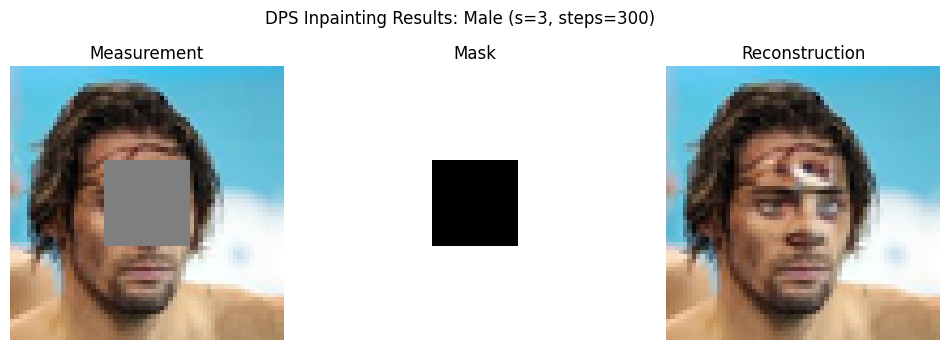

In [ ]:
x_batch, y_batch = next(iter(loader))

x_gt = x_batch[0:1].to(device)
gt_class_name = label_to_name_map[y_batch[0, ATTR_IDX].item()]

print(f"Sampled one image from dataset. Ground Truth Class: {gt_class_name}, Shape: {x_gt.shape}")

mask = torch.ones_like(x_gt).to(device)
mask[:, :, 22:42, 22:42] = 0.0 # Zero out bottom half
measurement = x_gt * mask

run_inference_dps(unet, emb, gt_class_name, 3, measurement, mask, zeta=0.35, steps=300)

In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF

def image_dps(image_paths, class_names, image_size=64, s=3, zeta=0.3, steps=350):
    if isinstance(image_paths, str):
        image_paths = [image_paths]
    
    for image_path, class_name in zip(image_paths, class_names):
        print(f"\n--- Processing: {image_path} ---")
        
        img = Image.open(image_path).convert('RGB')
        
        crop_size = min(img.size)
        img_cropped = transforms.CenterCrop(crop_size)(img)
        
        transform_rest = transforms.Compose([
            transforms.Resize(image_size, interpolation=transforms.InterpolationMode.LANCZOS),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        x = transform_rest(img_cropped).unsqueeze(0).to(device)
        
        mask = torch.ones_like(x).to(device)
        mask[:, :, 22:42, 22:42] = 0.0
        measurement = x * mask
        
        run_inference_dps(unet, emb, class_name, s=s, measurement=measurement, mask=mask, zeta=zeta, steps=steps)


--- Processing: ../data/people_samples/baptiste.png ---
Running DPS Inpainting... (Class: Male, Scale: 3)
Step 0/300 | t=999 | Loss: 12048.4453 | |Grad|: 1736.5275 | x_range: [-4.00, 3.74]
Step 10/300 | t=969 | Loss: 8463.9443 | |Grad|: 904.2394 | x_range: [-4.28, 3.73]
Step 20/300 | t=939 | Loss: 5902.3564 | |Grad|: 704.0045 | x_range: [-4.57, 3.74]
Step 30/300 | t=909 | Loss: 4614.0381 | |Grad|: 808.2599 | x_range: [-4.85, 3.80]
Step 40/300 | t=879 | Loss: 3692.3257 | |Grad|: 982.7573 | x_range: [-5.11, 3.84]
Step 50/300 | t=849 | Loss: 3986.1755 | |Grad|: 935.1824 | x_range: [-5.32, 3.82]
Step 60/300 | t=819 | Loss: 3299.2947 | |Grad|: 1049.5834 | x_range: [-5.51, 3.91]
Step 70/300 | t=789 | Loss: 3743.6707 | |Grad|: 1729.6288 | x_range: [-5.87, 4.12]
Step 80/300 | t=759 | Loss: 5879.7710 | |Grad|: 2244.5686 | x_range: [-6.10, 4.18]
Step 90/300 | t=729 | Loss: 5804.3965 | |Grad|: 1632.2958 | x_range: [-6.17, 4.51]
Step 100/300 | t=699 | Loss: 6991.2461 | |Grad|: 1310.2668 | x_range

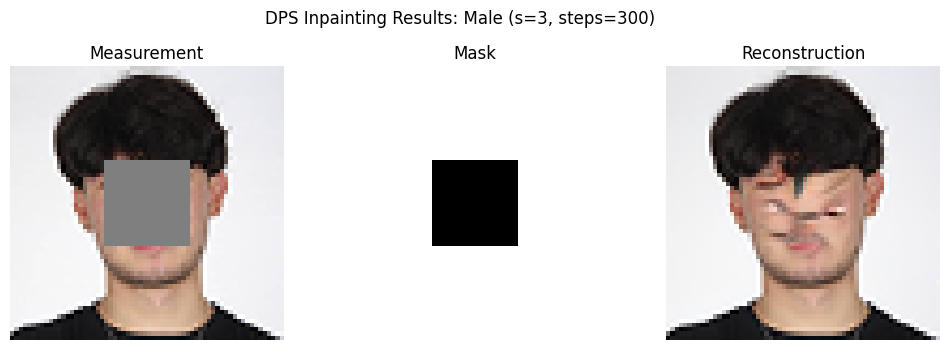


--- Processing: ../data/people_samples/angela.png ---
Running DPS Inpainting... (Class: Female, Scale: 3)
Step 0/300 | t=999 | Loss: 14867.4922 | |Grad|: 1384.3142 | x_range: [-3.78, 3.67]
Step 10/300 | t=969 | Loss: 10573.1523 | |Grad|: 2437.9929 | x_range: [-4.07, 3.46]
Step 20/300 | t=939 | Loss: 10249.1865 | |Grad|: 2952.3276 | x_range: [-4.49, 3.47]
Step 30/300 | t=909 | Loss: 10567.1777 | |Grad|: 3374.6753 | x_range: [-5.06, 3.48]
Step 40/300 | t=879 | Loss: 10829.5645 | |Grad|: 3276.1243 | x_range: [-5.86, 3.46]
Step 50/300 | t=849 | Loss: 10496.9395 | |Grad|: 2827.5435 | x_range: [-6.82, 3.47]
Step 60/300 | t=819 | Loss: 10753.8809 | |Grad|: 2509.1719 | x_range: [-7.95, 3.86]
Step 70/300 | t=789 | Loss: 11562.7695 | |Grad|: 2266.1228 | x_range: [-9.08, 4.12]
Step 80/300 | t=759 | Loss: 12886.2715 | |Grad|: 2073.0640 | x_range: [-9.94, 4.13]
Step 90/300 | t=729 | Loss: 14347.6865 | |Grad|: 1915.8087 | x_range: [-10.42, 4.13]
Step 100/300 | t=699 | Loss: 15590.8770 | |Grad|: 165

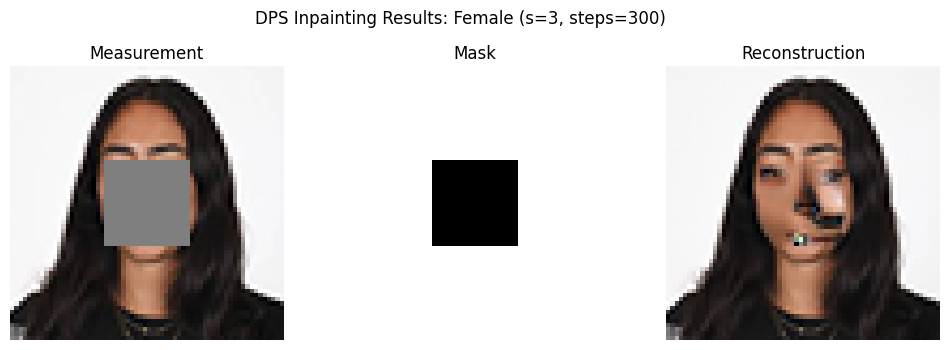


--- Processing: ../data/people_samples/aurel.png ---
Running DPS Inpainting... (Class: Male, Scale: 3)
Step 0/300 | t=999 | Loss: 10450.5215 | |Grad|: 3245.3816 | x_range: [-3.96, 3.52]
Step 10/300 | t=969 | Loss: 6910.8550 | |Grad|: 1006.0225 | x_range: [-4.73, 3.50]
Step 20/300 | t=939 | Loss: 4978.1040 | |Grad|: 524.8186 | x_range: [-5.64, 3.46]
Step 30/300 | t=909 | Loss: 3397.2217 | |Grad|: 540.3635 | x_range: [-6.83, 3.52]
Step 40/300 | t=879 | Loss: 3113.5105 | |Grad|: 629.7828 | x_range: [-8.32, 3.55]
Step 50/300 | t=849 | Loss: 2875.4302 | |Grad|: 858.5722 | x_range: [-9.96, 3.71]
Step 60/300 | t=819 | Loss: 3083.4260 | |Grad|: 948.0562 | x_range: [-11.48, 4.05]
Step 70/300 | t=789 | Loss: 4567.5063 | |Grad|: 1696.7346 | x_range: [-12.54, 4.30]
Step 80/300 | t=759 | Loss: 3108.9502 | |Grad|: 660.8636 | x_range: [-12.86, 4.65]
Step 90/300 | t=729 | Loss: 4072.4319 | |Grad|: 2164.7068 | x_range: [-14.19, 5.01]
Step 100/300 | t=699 | Loss: 3155.5554 | |Grad|: 786.4261 | x_range:

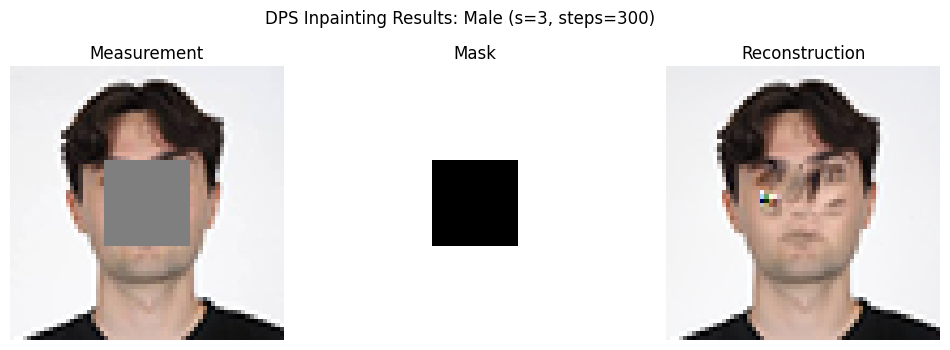


--- Processing: ../data/people_samples/cedric.png ---
Running DPS Inpainting... (Class: Male, Scale: 3)
Step 0/300 | t=999 | Loss: 10559.4375 | |Grad|: 2028.0288 | x_range: [-3.61, 3.64]
Step 10/300 | t=969 | Loss: 6490.8022 | |Grad|: 939.3773 | x_range: [-3.98, 3.65]
Step 20/300 | t=939 | Loss: 4457.8940 | |Grad|: 585.1716 | x_range: [-4.32, 3.73]
Step 30/300 | t=909 | Loss: 3051.5181 | |Grad|: 583.7338 | x_range: [-4.60, 3.84]
Step 40/300 | t=879 | Loss: 2684.7231 | |Grad|: 717.0955 | x_range: [-4.81, 3.80]
Step 50/300 | t=849 | Loss: 2810.1680 | |Grad|: 924.1152 | x_range: [-5.08, 3.72]
Step 60/300 | t=819 | Loss: 2988.2476 | |Grad|: 1110.5696 | x_range: [-5.80, 3.64]
Step 70/300 | t=789 | Loss: 3428.8171 | |Grad|: 1352.9523 | x_range: [-6.64, 3.73]
Step 80/300 | t=759 | Loss: 10703.2744 | |Grad|: 2252.1555 | x_range: [-7.37, 3.64]
Step 90/300 | t=729 | Loss: 10380.9307 | |Grad|: 1792.5085 | x_range: [-7.83, 3.79]
Step 100/300 | t=699 | Loss: 6656.3594 | |Grad|: 1536.3604 | x_range

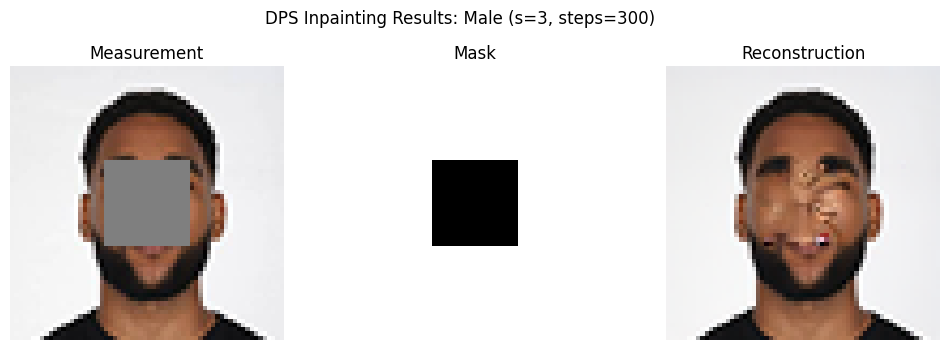


--- Processing: ../data/people_samples/eric.png ---
Running DPS Inpainting... (Class: Male, Scale: 3)
Step 0/300 | t=999 | Loss: 18902.5098 | |Grad|: 4811.7368 | x_range: [-3.78, 4.20]
Step 10/300 | t=969 | Loss: 5866.5747 | |Grad|: 1082.6763 | x_range: [-3.92, 4.37]
Step 20/300 | t=939 | Loss: 4528.4824 | |Grad|: 532.5410 | x_range: [-4.05, 4.50]
Step 30/300 | t=909 | Loss: 3238.7888 | |Grad|: 316.2404 | x_range: [-4.25, 4.50]
Step 40/300 | t=879 | Loss: 2477.6094 | |Grad|: 380.0118 | x_range: [-4.87, 4.50]
Step 50/300 | t=849 | Loss: 10643.3496 | |Grad|: 4480.2817 | x_range: [-5.53, 4.38]
Step 60/300 | t=819 | Loss: 3972.0613 | |Grad|: 1877.4432 | x_range: [-6.26, 4.44]
Step 70/300 | t=789 | Loss: 14232.9424 | |Grad|: 3487.3330 | x_range: [-7.18, 4.75]
Step 80/300 | t=759 | Loss: 15016.0889 | |Grad|: 2999.9021 | x_range: [-8.50, 5.05]
Step 90/300 | t=729 | Loss: 18068.8105 | |Grad|: 2596.3982 | x_range: [-10.52, 5.32]
Step 100/300 | t=699 | Loss: 19964.6523 | |Grad|: 2290.2932 | x_r

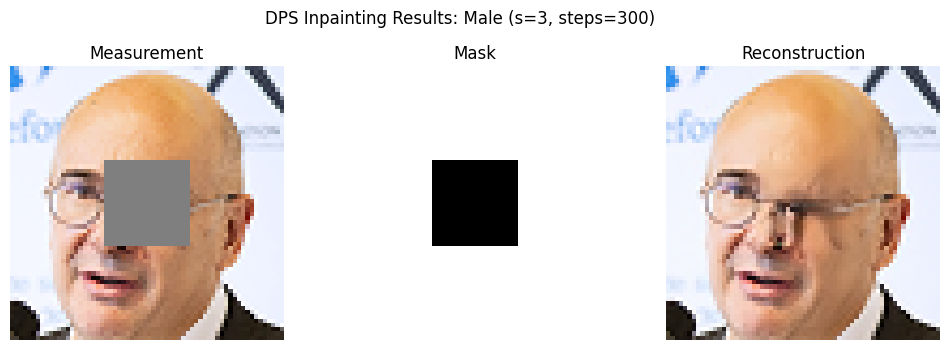


--- Processing: ../data/people_samples/khaled.png ---
Running DPS Inpainting... (Class: Male, Scale: 3)
Step 0/300 | t=999 | Loss: 11493.8779 | |Grad|: 2593.8630 | x_range: [-4.11, 3.54]
Step 10/300 | t=969 | Loss: 6587.1304 | |Grad|: 920.3880 | x_range: [-4.11, 3.53]
Step 20/300 | t=939 | Loss: 4923.2729 | |Grad|: 507.2126 | x_range: [-4.45, 3.67]
Step 30/300 | t=909 | Loss: 3538.8960 | |Grad|: 620.3722 | x_range: [-5.13, 3.72]
Step 40/300 | t=879 | Loss: 2672.4780 | |Grad|: 637.9842 | x_range: [-5.87, 3.71]
Step 50/300 | t=849 | Loss: 2813.9238 | |Grad|: 1218.4658 | x_range: [-6.54, 3.63]
Step 60/300 | t=819 | Loss: 3819.4172 | |Grad|: 1824.6825 | x_range: [-7.05, 3.63]
Step 70/300 | t=789 | Loss: 4106.8262 | |Grad|: 1755.4380 | x_range: [-7.97, 3.99]
Step 80/300 | t=759 | Loss: 4850.9688 | |Grad|: 1663.0751 | x_range: [-8.78, 4.56]
Step 90/300 | t=729 | Loss: 8101.1094 | |Grad|: 1583.1461 | x_range: [-9.40, 5.01]
Step 100/300 | t=699 | Loss: 5772.9331 | |Grad|: 958.1191 | x_range: 

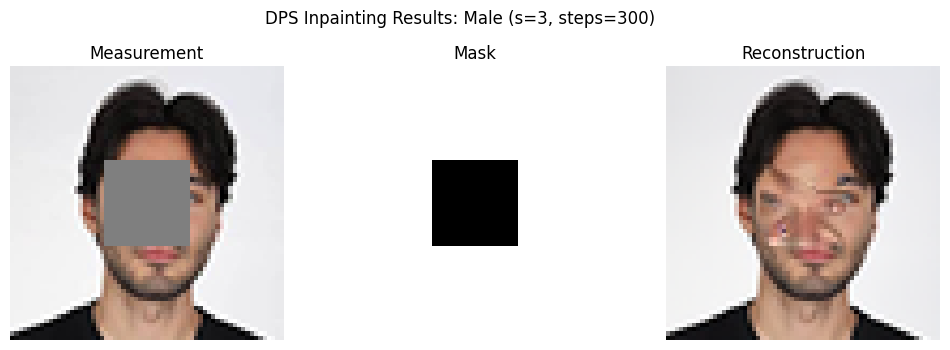

In [106]:
image_dps([
    "../data/people_samples/baptiste.png",
    "../data/people_samples/angela.png",
    "../data/people_samples/aurel.png",
    "../data/people_samples/cedric.png",
    "../data/people_samples/eric.png",
    "../data/people_samples/khaled.png",
], ["Male", "Female", "Male", "Male", "Male", "Male"], steps=300, s=3, zeta=0.2)

## 5. Comparaisons

On génère des images avec un paramètre de conditionnement différent à chaque fois.

Running DDIM Sampling (Steps=100)... Fast!


DDIM: 100%|██████████| 100/100 [00:34<00:00,  2.87it/s]


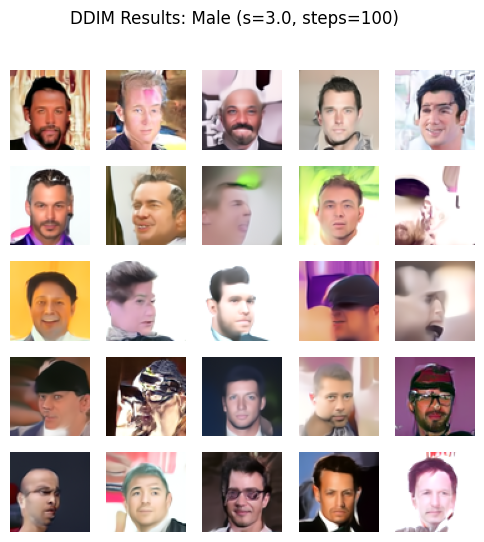

In [ ]:
run_inference_ddim(unet, emb, class_name="Male", s=3.0, n_steps=100)

Running DDIM Sampling (Steps=100)... Fast!


DDIM: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


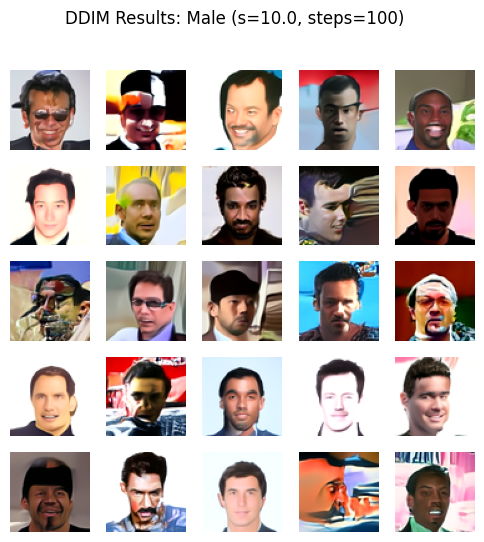

In [ ]:
run_inference_ddim(unet, emb, class_name="Male", s=10.0, n_steps=100)

Running DDIM Sampling (Steps=100)... Fast!


DDIM: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


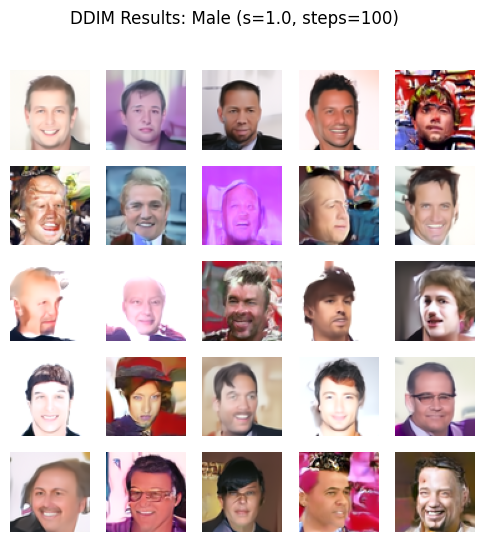

In [ ]:
run_inference_ddim(unet, emb, class_name="Male", s=1.0, n_steps=100)

Running DDIM Sampling (Steps=100)... Fast!


DDIM: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


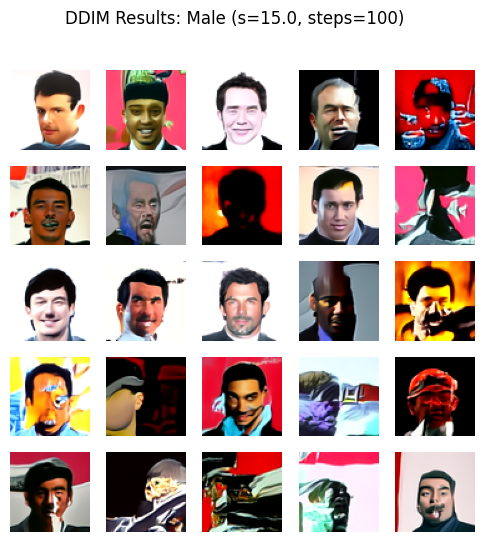

In [ ]:
run_inference_ddim(unet, emb, class_name="Male", s=15.0, n_steps=100)